In [1]:
%pylab inline
import matplotlib as mpl
mpl.use("pgf")
pgf_with_pdflatex = {
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": [
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage{cmbright}",
         ]
}
mpl.rcParams.update(pgf_with_pdflatex)
import matplotlib.pyplot as plt
import numpy as np
import pylab as pb
import GPy
import seaborn as sns
pb.ion()
sns.set_context("paper")

/Users/juangilopez/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
 /Users/juangilopez/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning:The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.


Populating the interactive namespace from numpy and matplotlib


## Sparse Hierarchical GP Regression with GPy

Generating the data set, for this case using the LMC:

In [46]:
d = 3 # Output dimensions
time_stamps = 50 # amount of inputs
np.random.seed(2)
n_icm = 2
kg = GPy.kern.Matern32(1, variance=1., lengthscale=5.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d)
kf = (GPy.kern.Matern32(1, variance=.1, lengthscale=2.) + GPy.kern.White(1, variance=0.001))**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d)

for i in range(0, n_icm):
    kg_variance = np.random.random_sample(1) + 1.0
    kg_length = np.random.random_sample(1) + 5.0
    kg = kg + GPy.kern.Matern32(1, variance=kg_variance, lengthscale=kg_length)**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d)
    
    kf_variance = np.random.random_sample(1)
    kf_length = np.random.random_sample(1) + 2.0
    kf = kf + (GPy.kern.Matern32(1, variance=kf_variance, lengthscale=kf_length) + GPy.kern.White(1, variance=0.001))**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d)

x_parent = np.linspace(0, 2*np.pi, time_stamps)
inp = x_parent[:, None]
T = np.r_[np.c_[inp, np.zeros_like(inp)]]
for i in range(1,d):
    T = np.r_[T, np.c_[inp, np.ones_like(inp)*i]]

C_parent_gen = kg.K(T, None)
#plt.figure(1, figsize=(3,3))
#plt.imshow(C_parent_gen, cmap=plt.cm.hot)
#plt.title('Covariance of the parent process')
#plt.colorbar()

Generating the parent signal

(50,) (50,)


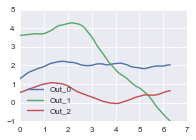

In [47]:
g_mean = np.zeros(T.shape[0])
np.random.seed(50)
g_n = np.random.multivariate_normal(g_mean, C_parent_gen, 1)
divs = np.linspace(0,d*time_stamps, d + 1)
print T[0:50,0].shape, g_n[0, 0:50].shape
plt.figure(1, figsize=(3,2))
for i in range(0, divs.shape[0] - 1):
    a = divs[i]
    b = divs[i+1]
    mlabel = 'Out_' + str(i)
    plt.plot(T[a:b,0], g_n[0,a:b], label=mlabel)
    plt.legend(loc='lower left')

In [48]:
np.random.seed(20)
n_sons = 5
fn_list = []
C_sons_gen = kf.K(T, None)
g_n = g_n.squeeze()
#plt.figure(1, figsize=(3,3))
#plt.imshow(C_sons_gen, cmap=plt.cm.hot)
#plt.title('Covariance of the replicate process')
#plt.colorbar()

Generating the children Signal:

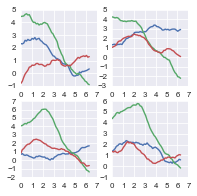

In [49]:
plt.figure(1, figsize=(3,3))
for i in range(0,n_sons):
    f_n = np.random.multivariate_normal(g_n, C_sons_gen, 1)
    f_n = np.squeeze(f_n)
    fn_list.append(f_n)
    if i < 4:
        plt.subplot(2,2,i + 1)
        #plt.title('Replicate ' + str(i))
        for j in range(0, divs.shape[0] - 1):        
            a = divs[j]
            b = divs[j+1]
            mlabel = 'Out_' + str(i)
            plt.plot(T[a:b,0], f_n[a:b])#, label=mlabel)
            #plt.legend(loc='upper right')

#plt.savefig('../reports/report_5/rep_sig_sd.pgf')

In [42]:
def SetInputMOHGP(sub_data_list, minp, multioutput_alone=0):
    ini_x = sub_data_list[0]
    inp = minp[0]
    #inp = np.arange(ini_x.shape[1])
    ini_T = np.r_[np.c_[inp, np.zeros_like(inp)]]
    ini_Y = np.r_[np.c_[ini_x[0,:]]]
    for i in range(1,ini_x.shape[0]):
        ini_T = np.r_[ini_T, np.c_[inp, np.ones_like(inp)*i]]
        ini_Y = np.r_[ini_Y, np.c_[ini_x[i,:]]]
    
    tmp_mlast = ini_x.shape[0]
    #ini_T.dtype = 'float64'
    T_hat = np.c_[ini_T, np.zeros_like(ini_T[:,1])]
    Y_hat = ini_Y
    for i in range(1,len(sub_data_list)):
        mdata = sub_data_list[i]
        mlast = tmp_mlast
        #inp = np.arange(mdata.shape[1])
        inp = minp[i]
        tmp_T = np.r_[np.c_[inp, np.ones_like(inp)*multioutput_alone*mlast]]
        #tmp_T.dtype = 'float64'
        tmp_Y = np.r_[np.c_[mdata[0,:]]]
        #print mlast
        for j in range(1,mdata.shape[0]):
            #print j
            tmp_T = np.r_[tmp_T, np.c_[inp, np.ones_like(inp)*j + (multioutput_alone*mlast)]]
            tmp_Y = np.r_[tmp_Y, np.c_[mdata[j,:]]]
            tmp_mlast += 1
        # tmp_mlast += 1
        T_hat = np.r_[T_hat, np.c_[tmp_T, np.ones_like(tmp_T[:,1])*i]]
        Y_hat = np.r_[Y_hat, np.c_[tmp_Y]]
    
    return T_hat, Y_hat

def testTrainDataSet(l, r, fn_list, minp, zinp, mflag=-1):    
    train_list = []
    test_list = []
    inp_train_list = []
    inp_test_list = []
    idx_children = 0 #np.random.randint(0,len(fn_list))
    ind_points_list = []
    for mval in fn_list:
        tmp_arr = np.zeros((d, time_stamps))
        a = 0
        b = time_stamps
        for i in range(0,d):
            tmp_arr[i,:] = mval[a:b]
            a = b
            b += time_stamps
            
        train_list.append(tmp_arr)
        inp_train_list.append(minp)
        ind_points_list.append(zinp)
        
    if mflag != -1:
        index = np.random.permutation(time_stamps)
        bool_array_test = np.zeros(time_stamps, dtype=bool)
        bool_array_train = np.zeros(time_stamps, dtype=bool)
        bool_array_test[index[l:r]] = True
        bool_array_train = np.logical_not(bool_array_test)
        
        test_list.append(train_list[idx_children][:, bool_array_test])
        inp_test_list.append(minp[bool_array_test])
        
        train_list[idx_children] = train_list[idx_children][:, bool_array_train]           
        inp_train_list[idx_children] = minp[bool_array_train]
        
        
                
    return train_list, test_list, inp_train_list, inp_test_list, ind_points_list

def MOHGPSparseModel(T_hat, Y_hat, Z_hat, d):
    k1 = GPy.kern.Matern32(1, variance=5., lengthscale=20.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d)
    k2 = (GPy.kern.Matern32(1, variance=1., lengthscale=5.) + GPy.kern.White(1, variance=1.))**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d)
    #for i in range(0, n_icm):
       # k1 = k1 + GPy.kern.Matern32(1, variance=5., lengthscale=20.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d)
        #k2 = k2 + (GPy.kern.Matern32(1, variance=1., lengthscale=5.) + GPy.kern.White(1, variance=1.))**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d)
    
    
    k1.name = 'parent'
    k2.name = 'children'
    kernels = [k1,k2] 
    HGP = GPy.kern._src.independent_outputs.Hierarchical(kernels)
    model = GPy.models.SparseGPRegression(T_hat, Y_hat, Z=Z_hat, kernel=HGP) # Making a normal regression
    #model.likelihood.variance = 0.01
    #print 'hey viejo 1'
    #model.optimize()
    #model.optimize_restarts(num_restarts = 30)
    return model

Trying The sparse GP regression with the hierarchical model

In [50]:
n_ind_var = 10
zinp = np.linspace(0, 2*np.pi, n_ind_var)
minp = x_parent.copy()
train_list, _, inp_train, _, ind_points_list = testTrainDataSet(0, time_stamps, fn_list, minp, zinp)
T_hat_train, Y_hat_train = SetInputMOHGP(train_list, inp_train)
Z_hat,_ = SetInputMOHGP(train_list, ind_points_list)
model_mohgp_sp = MOHGPSparseModel(T_hat_train, Y_hat_train, Z_hat, d)

NotImplementedError: 